Task 2 Question 1   
Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X,Y) to the pixel colors (R,G,B). Here, (X,Y) represents the coordinates of the pixels, and (R,G,B) represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

In [ ]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from einops import rearrange
import gc
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
if os.path.exists('modizi.jpg'):
    print('image exists')
else:
  !wget https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg -O Doge.jpg


--2024-09-19 18:23:46--  https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32544 (32K) [image/jpeg]
Saving to: ‘Doge.jpg’

Doge.jpg            100%[===================>]  31.78K  --.-KB/s    in 0.01s   

2024-09-19 18:23:46 (2.13 MB/s) - ‘Doge.jpg’ saved [32544/32544]



In [8]:
img = torchvision.io.read_image("Doge.jpg")
print(img.shape)

torch.Size([3, 263, 350])


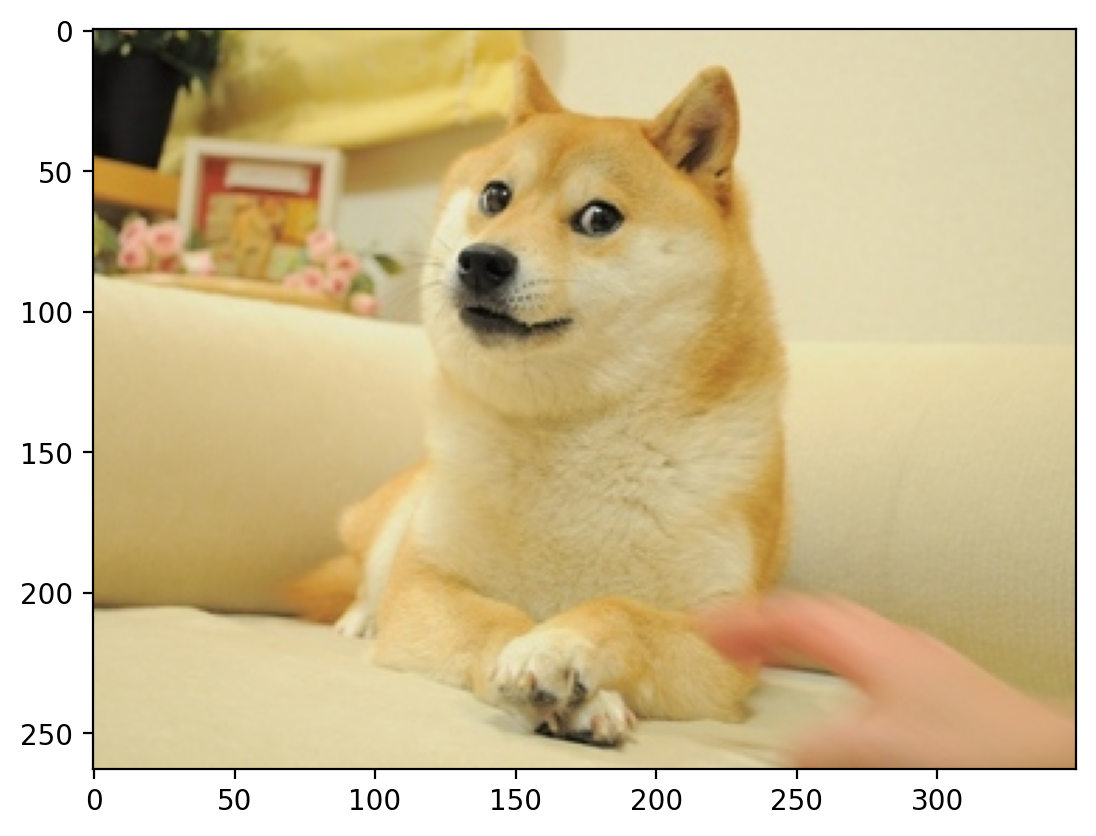

In [9]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [10]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler_img = scaler.fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [11]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled.shape


torch.Size([3, 263, 350])

In [12]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.4309, 0.2764, 0.2073,  ..., 0.8699, 0.8618, 0.8618],
         [0.5163, 0.3780, 0.2317,  ..., 0.8740, 0.8618, 0.8618],
         [0.4878, 0.4065, 0.2439,  ..., 0.8699, 0.8618, 0.8577],
         ...,
         [0.8659, 0.8659, 0.8699,  ..., 0.7805, 0.7886, 0.7846],
         [0.8659, 0.8699, 0.8699,  ..., 0.7683, 0.7764, 0.7724],
         [0.8659, 0.8699, 0.8699,  ..., 0.7561, 0.7642, 0.7642]],

        [[0.4512, 0.2927, 0.2236,  ..., 0.8374, 0.8374, 0.8374],
         [0.5244, 0.3943, 0.2480,  ..., 0.8415, 0.8374, 0.8374],
         [0.4919, 0.4146, 0.2602,  ..., 0.8374, 0.8374, 0.8333],
         ...,
         [0.8171, 0.8171, 0.8211,  ..., 0.6016, 0.6016, 0.5976],
         [0.8171, 0.8211, 0.8211,  ..., 0.5894, 0.5894, 0.5854],
         [0.8171, 0.8211, 0.8211,  ..., 0.5813, 0.5772, 0.5772]],

        [[0.2846, 0.1504, 0.1301,  ..., 0.6911, 0.6911, 0.6911],
         [0.3618, 0.2520, 0.1545,  ..., 0.6951, 0.6911, 0.6911],
         [0.3211, 0.2642, 0.1667,  ..., 0.6911, 0.6911, 0.

In [23]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 0, 60, 200, 200)
crop.shape

torch.Size([3, 200, 200])

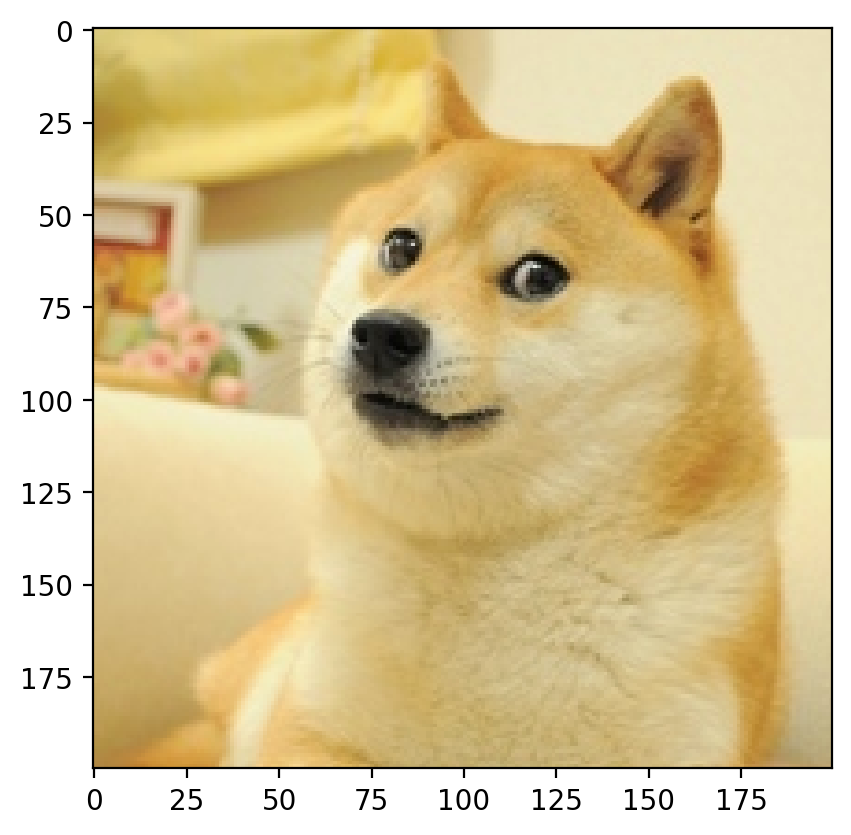

In [24]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [25]:
crop = crop.to(device)

In [26]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [27]:
modizi_X, modizi_Y = create_coordinate_map(crop)

modizi_X.shape, modizi_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [28]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(modizi_X.cpu())

# Scale the X coordinates
modizi_X_scaled = scaler_X.transform(modizi_X.cpu())

# Move the scaled X coordinates to the GPU
modizi_X_scaled = torch.tensor(modizi_X_scaled).to(device)

# Set to dtype float32
modizi_X_scaled = modizi_X_scaled.float()

In [29]:
modizi_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])

In [30]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [31]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    error_list = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
            error_list.append(loss.item())
    return error_list

In [32]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    y_pred = outputs.cpu()
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return y_pred

In [33]:
modizi_X_scaled.shape[0]

40000

In [34]:
# creating RFF features
def create_rff_features(X, num_features, sigma,batch_size=1000):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    # compute the RFF transformation for a batch becoz rff for full sample require large size ram
    # num_samples = X.shape[0]
    # X_rff = []

    # for start_idx in range(0, num_samples, batch_size):
    #     end_idx = min(start_idx + batch_size, num_samples)
    #     batch = X[start_idx:end_idx]
          # Apply RFF transformation on each batch
    #     transformed_batch = rff.fit_transform(batch)
    #     X_rff.append(transformed_batch)

    #     # Free up memory
    #     del batch  # Delete the processed batch

    # X_rff = np.vstack(X_rff)  # Stack all batches together
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [35]:
X_rff = create_rff_features(modizi_X_scaled, 30000, 0.008) #37500
X_rff.shape

torch.Size([40000, 30000])

In [36]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
epocs = 1000
learning_rate = 0.05
error_list = train(net, learning_rate, X_rff, modizi_Y, epocs) #2500 earlier lr was 0.05 but 0.5 gives faster converges=

Epoch 0 loss: 0.508946
Epoch 100 loss: 0.000090
Epoch 200 loss: 0.000065
Epoch 300 loss: 0.000062
Epoch 400 loss: 0.000061
Epoch 500 loss: 0.000061
Epoch 600 loss: 0.000061
Epoch 700 loss: 0.000061
Epoch 800 loss: 0.000061
Epoch 900 loss: 0.000061


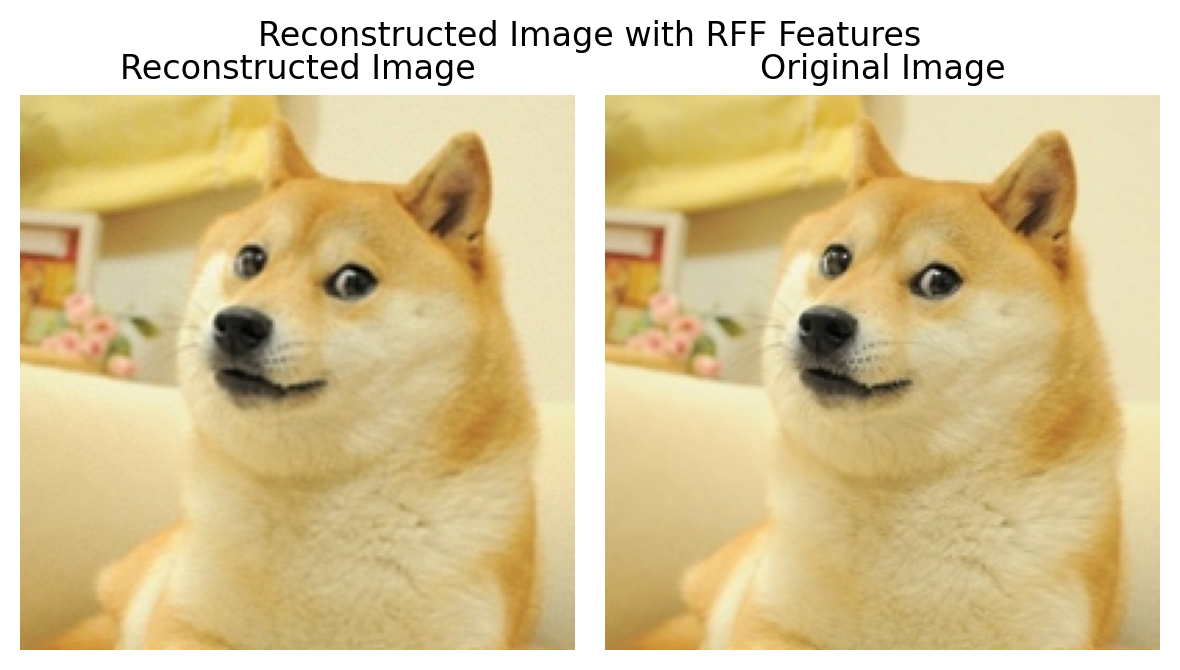

In [37]:
y_pred=plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [38]:
y_pred.shape

torch.Size([200, 200, 3])

In [39]:
crop.shape

torch.Size([3, 200, 200])

In [40]:
y_pred = rearrange(y_pred, 'h w c -> c h w') #making ypred shape same as crop
y_pred.shape

torch.Size([3, 200, 200])

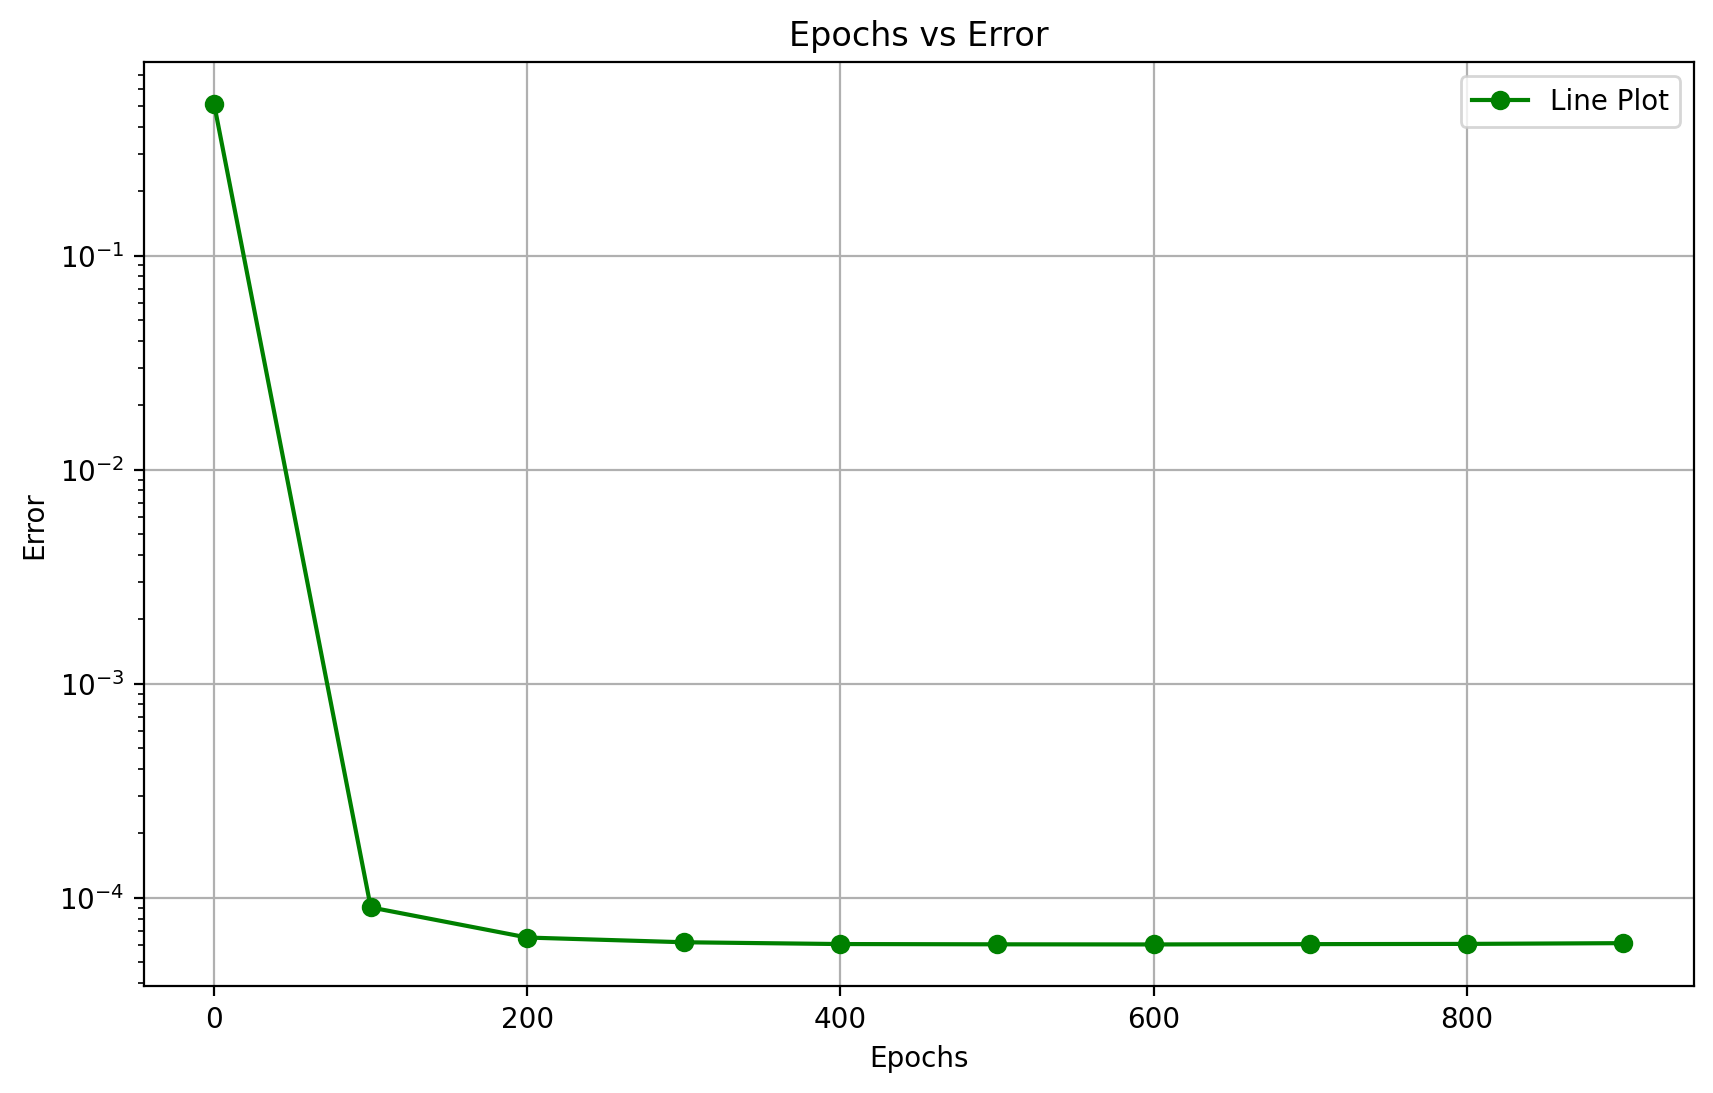

In [41]:
xaxis = np.arange(0, epocs, 100)
plt.figure(figsize=(10, 6))
plt.plot(xaxis, error_list, marker='o', linestyle='-', color='g', label='Line Plot')

plt.yscale('log')
plt.title('Epochs vs Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

plt.grid(True)
plt.show()


In [42]:
def calculate_rmse(originalimage, predictedimage):
    mse = torch.mean((originalimage - predictedimage) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()


def calculate_psnr(originalimage, predictedimage, max_pixel=1.0):
    rmse = calculate_rmse(originalimage, predictedimage)
    if rmse == 0:
        return float('inf')  # If RMSE is zero, PSNR is infinite
    max_pixel_tensor = torch.tensor(max_pixel)
    rmse_tensor = torch.tensor(rmse)
    psnr = 20 * torch.log10(max_pixel_tensor / rmse_tensor)
    return psnr.item()

rmse_value = calculate_rmse(crop,y_pred)
psnr_value = calculate_psnr(crop,y_pred)

print(f"Root Mean Squarred Error: {rmse_value}")
print(f"Peak Signal-to-Noise Ratio: {psnr_value} dB")

Root Mean Squarred Error: 0.007825461795117271
Peak Signal-to-Noise Ratio: 42.129798889160156 dB


$Root\;Mean \;Squarred\; Error\;- \;0.007825461795117271$  
$Peak\;Signal-to-Noise\; Ratio\; -\;42.129798889160156 dB \;dB$

Task 2 Question 2

Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time ( t ) to amplitude ( A ) , where t is the time point, and A is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction.

In [ ]:
!wget https://github.com/ShivanshSoni-AI/Saas-AI/raw/main/SMW295.wav

--2024-09-18 16:45:44--  https://github.com/ShivanshSoni-AI/Saas-AI/raw/main/SMW295.wav
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShivanshSoni-AI/Saas-AI/main/SMW295.wav [following]
--2024-09-18 16:45:45--  https://raw.githubusercontent.com/ShivanshSoni-AI/Saas-AI/main/SMW295.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1947286 (1.9M) [audio/wav]
Saving to: ‘SMW295.wav’

SMW295.wav          100%[===================>]   1.86M  --.-KB/s    in 0.07s   

2024-09-18 16:45:45 (24.9 MB/s) - ‘SMW295.wav’ saved [1947286/1947286]



In [ ]:
from IPython.display import Audio
Audio('SMW295.wav')

In [ ]:
import torchaudio
audio, sr = torchaudio.load('SMW295.wav')

In [ ]:
print(audio.shape)
audio = audio[0]

torch.Size([2, 486767])


In [ ]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 11.03780045351474 seconds


In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

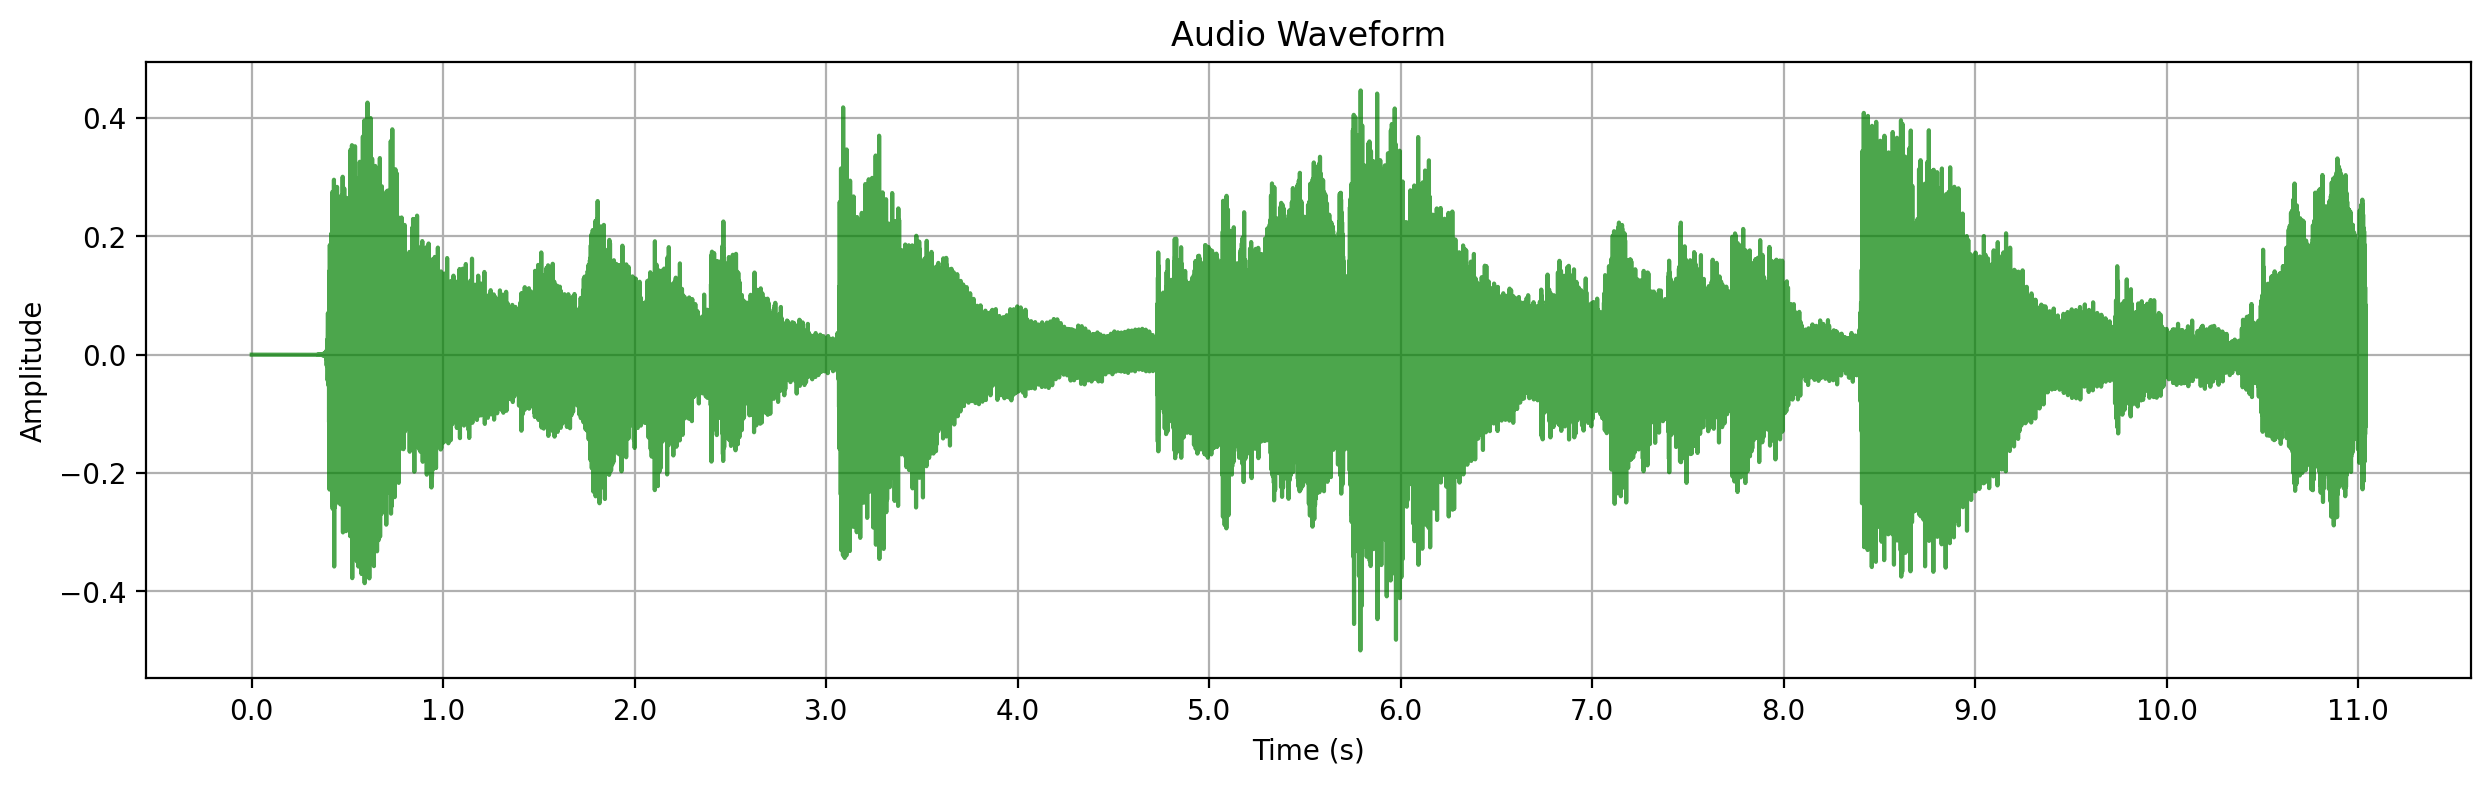

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [ ]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)

torch.Size([88200])
tensor([ 0.0395,  0.0343,  0.0296,  ..., -0.1129, -0.1208, -0.1186])


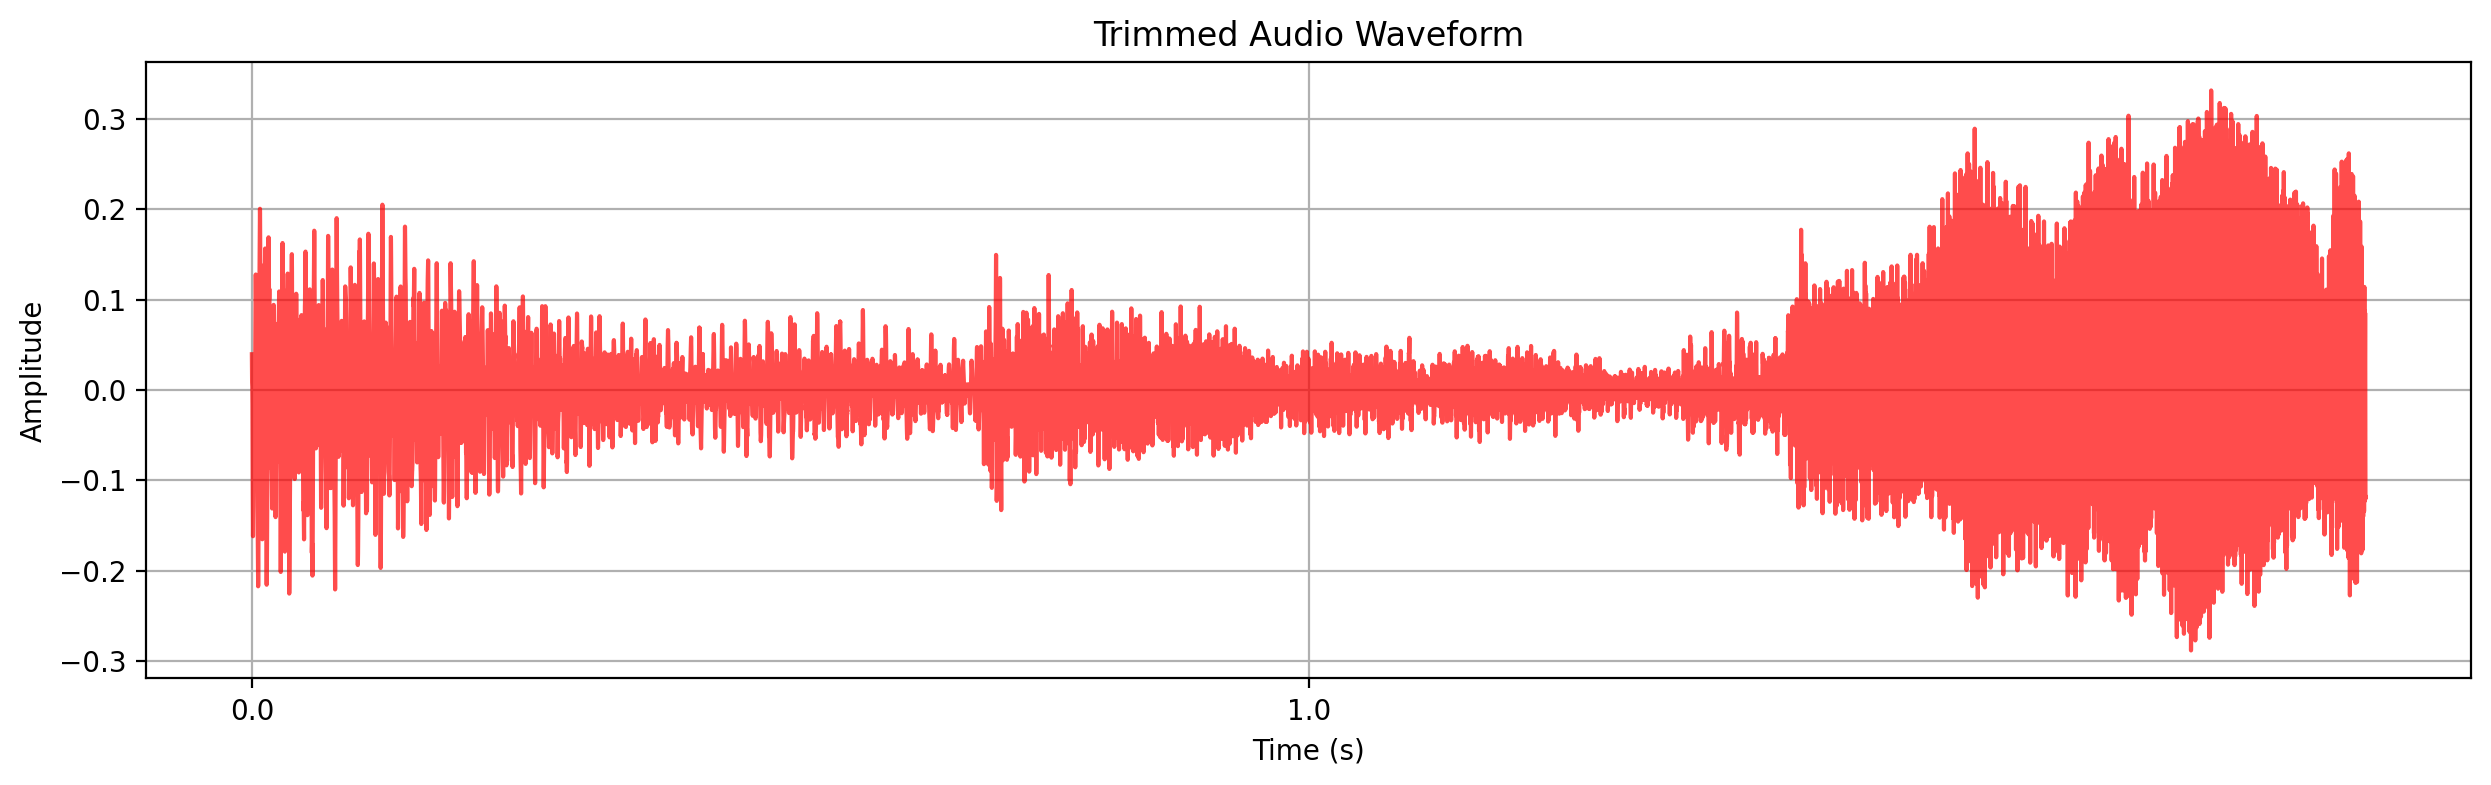

In [ ]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


In [ ]:
Audio(audio, rate = sr)

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


In [ ]:
print(pred_audio.shape)
print(audio.shape)

(88200,)
torch.Size([88200])


In [ ]:
Audio(pred_audio, rate = sr)

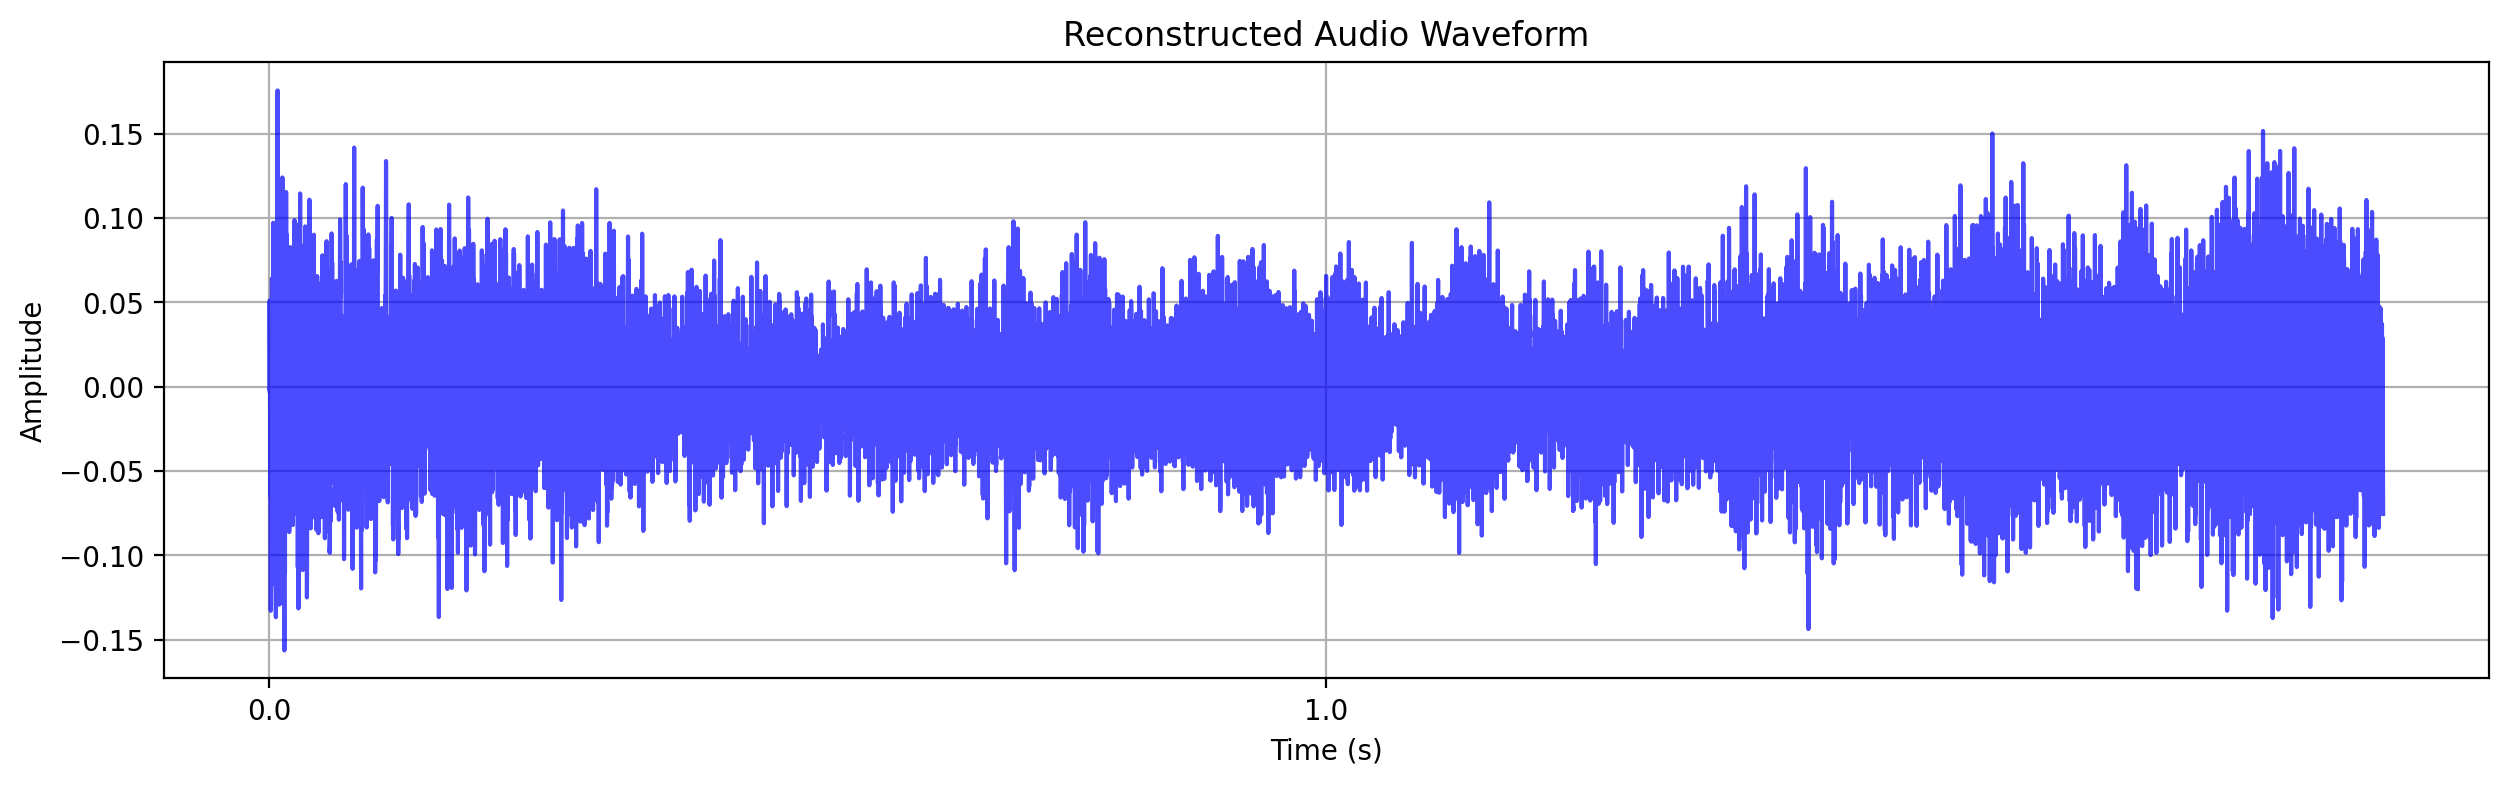

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

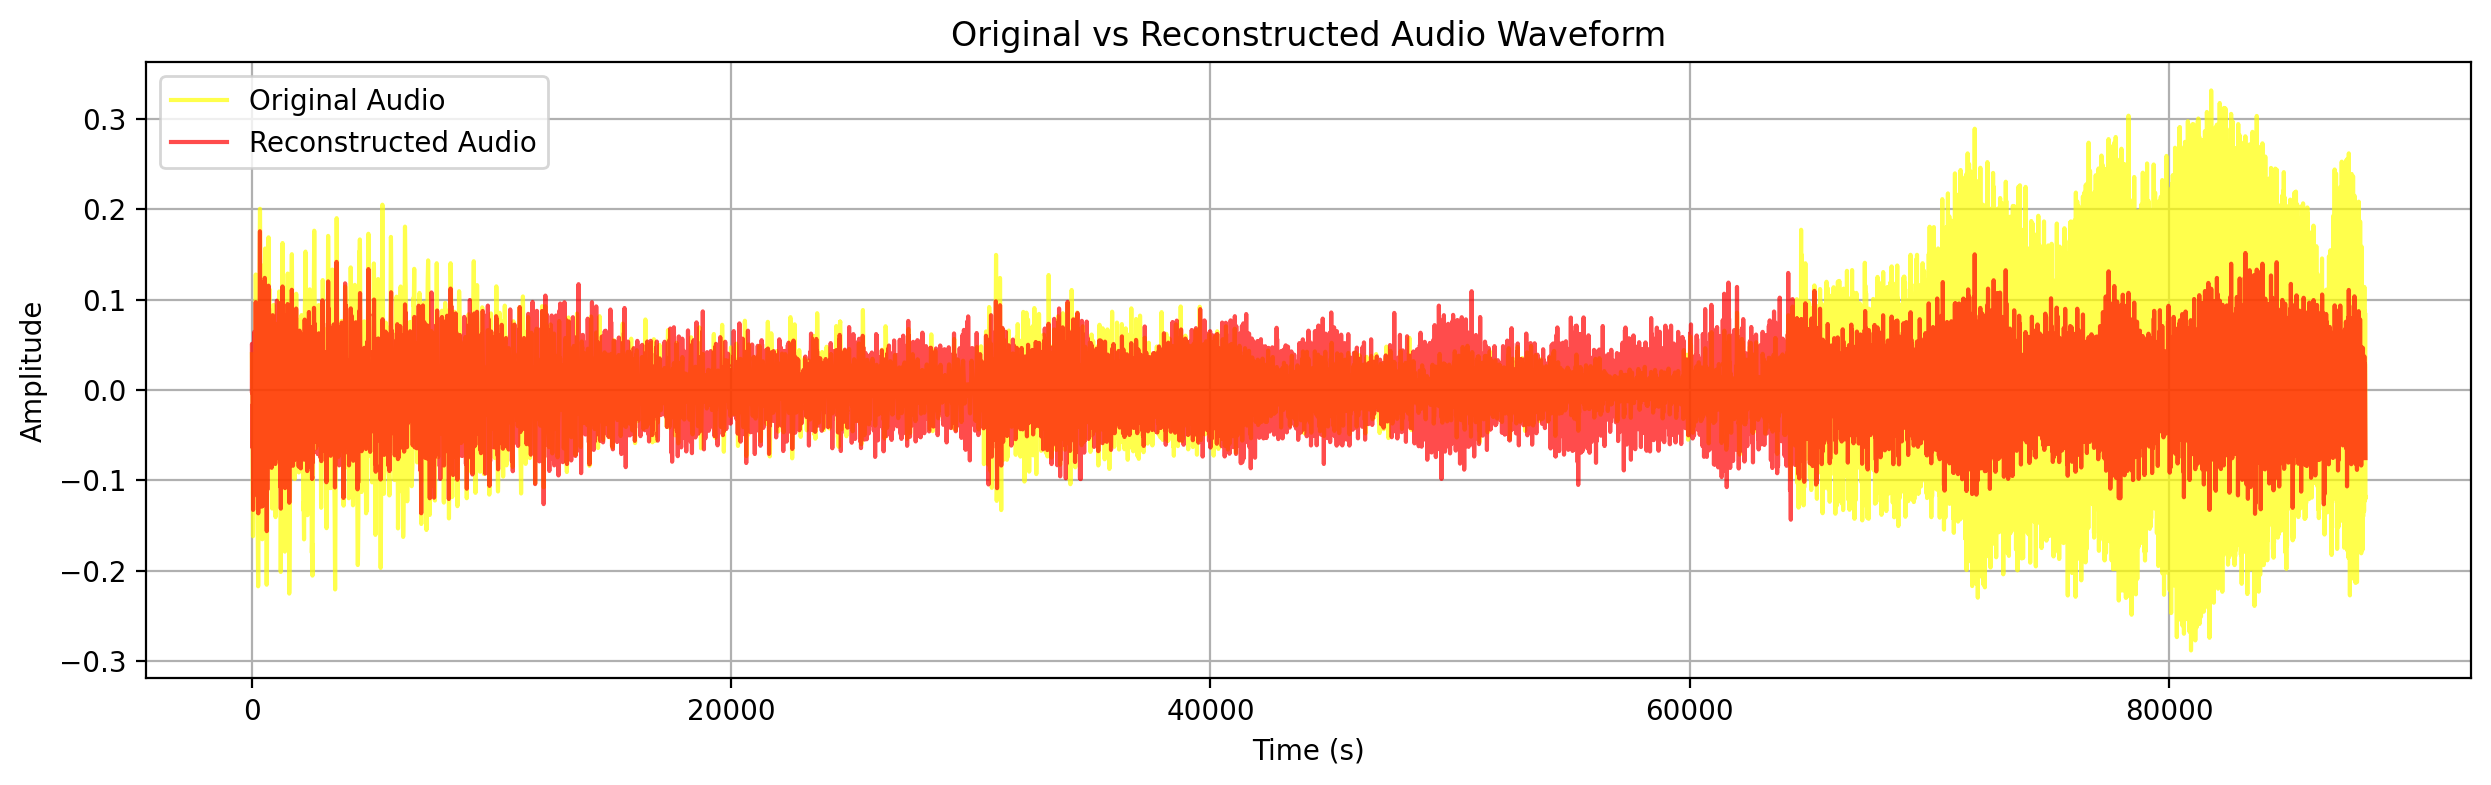

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'yellow', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred_audio_tensor = torch.tensor(pred_audio)
type(pred_audio_tensor)

torch.Tensor

In [ ]:
def calculate_rmse_audio(Originalaudio, Predictedaudio):

    rmse = torch.sqrt(torch.mean((Originalaudio - Predictedaudio) ** 2))
    return rmse.item()

def calculate_snr_audio(Originalaudio, Predictedaudio):

    Originalaudio_power = torch.mean(Originalaudio ** 2)
    Predictedaudio_power = torch.mean(Predictedaudio ** 2)

    if Predictedaudio_power == 0:
        return float('inf')  # Infinite SNR if there is no Predictedaudio

    snr = 10 * torch.log10(Originalaudio_power / Predictedaudio_power)
    return snr.item()

rsme_audio = calculate_rmse_audio(audio,pred_audio_tensor)
snr_audio = calculate_snr_audio(audio,pred_audio_tensor)

print(f'Root Mean Squared Error: {rsme_audio}')
print(f'Signal to Noise ratio: {snr_audio}')

Root Mean Squared Error: 0.0491705983877182
Signal to Noise ratio: 4.537572860717773


$Root \;Mean\; Squared\; Error:\;0.0491705983877182$   
$Signal\; to\; Noise\; ratio:\;4.537572860717773$